# Configuration

In [1]:
import os
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump, load

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier

In [2]:
RANDOM_STATE = 42

TRAIN_PATH = "train_data.csv"
TEST_PATH  = "test_data.csv"   # if missing, we will create a split from train as a placeholder

ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

# Load data, standardize column names, identify target

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.columns = [c.strip() for c in train_df.columns]

# Identify target and index columns robustly
target_candidates = [c for c in train_df.columns if "bankrupt" in c.lower()]
if not target_candidates:
    raise ValueError("Couldn't find a target column containing 'bankrupt'.")
TARGET_COL = target_candidates[0]

index_candidates = [c for c in train_df.columns if c.lower() in ("index", "id", "company_id")]
INDEX_COL = index_candidates[0] if index_candidates else None

print("TARGET_COL:", TARGET_COL)
print("INDEX_COL:", INDEX_COL)
print("Train shape:", train_df.shape)
print("Target distribution:\n", train_df[TARGET_COL].value_counts(normalize=False))

# Load test if available, else create a placeholder split (replace with your real test_data.csv)
if Path(TEST_PATH).exists():
    test_df = pd.read_csv(TEST_PATH)
    test_df.columns = [c.strip() for c in test_df.columns]
    print("\nLoaded TEST_PATH:", TEST_PATH, "shape:", test_df.shape)
else:
    from sklearn.model_selection import train_test_split
    train_df, test_df = train_test_split(
        train_df, test_size=0.17, random_state=RANDOM_STATE, stratify=train_df[TARGET_COL]
    )
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    print("\nTEST_PATH not found; created a stratified split as a placeholder.")
    print("New train shape:", train_df.shape, "New test shape:", test_df.shape)


TARGET_COL: Bankrupt?
INDEX_COL: Index
Train shape: (5807, 97)
Target distribution:
 Bankrupt?
0    5609
1     198
Name: count, dtype: int64

TEST_PATH not found; created a stratified split as a placeholder.
New train shape: (4819, 97) New test shape: (988, 97)


# Custom transformers (drop cols, correlation filter, log+topcode indicators)

In [4]:
class ColumnNameStripper(BaseEstimator, TransformerMixin):
    """Ensures any incoming DataFrame has stripped column names."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X.columns = [str(c).strip() for c in X.columns]
        return X


class ColumnDropper(BaseEstimator, TransformerMixin):
    """Drops specified columns if they exist."""
    def __init__(self, drop_cols=None):
        self.drop_cols = drop_cols or []
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        cols = [c for c in self.drop_cols if c in X.columns]
        return X.drop(columns=cols)


class HighCorrelationFilter(BaseEstimator, TransformerMixin):
    """
    Drops features with absolute correlation above threshold.
    Keeps the first feature in each correlated group.
    """
    def __init__(self, threshold=0.98):
        self.threshold = float(threshold)

    def fit(self, X, y=None):
        Xdf = pd.DataFrame(X).copy()
        corr = Xdf.corr(numeric_only=True).abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > self.threshold)]
        self.keep_cols_ = [c for c in Xdf.columns if c not in to_drop]
        self.dropped_cols_ = to_drop
        return self

    def transform(self, X):
        Xdf = pd.DataFrame(X).copy()
        return Xdf[self.keep_cols_]


class SkewAndTopcodeHandler(BaseEstimator, TransformerMixin):
    """
    For very large-scale nonnegative columns:
      - add indicator: is_topcoded__{col} if value >= sentinel_fraction * max
      - clip at sentinel_fraction * max, then log1p
    For other columns: pass through unchanged.
    """
    def __init__(self, huge_max_threshold=1e6, sentinel_fraction=0.95):
        self.huge_max_threshold = float(huge_max_threshold)
        self.sentinel_fraction = float(sentinel_fraction)

    def fit(self, X, y=None):
        Xdf = pd.DataFrame(X).copy()

        self.cols_in_ = list(Xdf.columns)
        self.huge_cols_ = []
        self.max_ = {}
        self.clip_ = {}

        for c in self.cols_in_:
            s = Xdf[c]
            mx, mn = float(s.max()), float(s.min())
            if mx > self.huge_max_threshold and mn >= 0:
                self.huge_cols_.append(c)
                self.max_[c] = mx
                self.clip_[c] = self.sentinel_fraction * mx

        self.cols_out_ = self.cols_in_ + [f"is_topcoded__{c}" for c in self.huge_cols_]
        return self

    def transform(self, X):
        Xdf = pd.DataFrame(X, columns=self.cols_in_).copy()

        for c in self.huge_cols_:
            clip_val = self.clip_[c]
            Xdf[f"is_topcoded__{c}"] = (Xdf[c].values >= clip_val).astype(float)
            Xdf[c] = np.log1p(np.minimum(Xdf[c].values, clip_val))

        return Xdf


class ConstantColumnDropper(BaseEstimator, TransformerMixin):
    """Drops columns with <=1 unique value (constant)."""
    def fit(self, X, y=None):
        Xdf = pd.DataFrame(X).copy()
        nunique = Xdf.nunique(dropna=False)
        self.drop_cols_ = nunique[nunique <= 1].index.tolist()
        self.keep_cols_ = [c for c in Xdf.columns if c not in self.drop_cols_]
        return self
    def transform(self, X):
        Xdf = pd.DataFrame(X).copy()
        return Xdf[self.keep_cols_]


# Step-0: Fit preprocessing objects and save with joblib

In [5]:
# Build raw X/y for training
drop_cols = [TARGET_COL]
if INDEX_COL is not None:
    drop_cols.append(INDEX_COL)

X_train_raw = train_df.drop(columns=drop_cols).copy()
y_train = train_df[TARGET_COL].astype(int).values

# Keep Liability-Assets Flag for classifiers, but DROP it for clustering to avoid "7-point singleton cluster" behavior
LIAB_ASSET_FLAG = None
for c in X_train_raw.columns:
    if "liability-assets flag" in c.lower():
        LIAB_ASSET_FLAG = c
        break

core_preprocess = Pipeline(steps=[
    ("strip_names", ColumnNameStripper()),
    ("drop_constant", ConstantColumnDropper()),
    ("corr_filter", HighCorrelationFilter(threshold=0.98)),
    ("skew_topcode", SkewAndTopcodeHandler(huge_max_threshold=1e6, sentinel_fraction=0.95)),
    ("robust_scale", RobustScaler(with_centering=True, with_scaling=True)),
    ("quantile_gauss", QuantileTransformer(
        output_distribution="normal",
        n_quantiles=2000,
        random_state=RANDOM_STATE
    )),
])

# For clustering embedding: drop the near-constant flag before PCA (optional but recommended)
cluster_preprocess = Pipeline(steps=[
    ("strip_names", ColumnNameStripper()),
    ("drop_cols", ColumnDropper(drop_cols=[LIAB_ASSET_FLAG] if LIAB_ASSET_FLAG else [])),
    ("drop_constant", ConstantColumnDropper()),
    ("corr_filter", HighCorrelationFilter(threshold=0.98)),
    ("skew_topcode", SkewAndTopcodeHandler(huge_max_threshold=1e6, sentinel_fraction=0.95)),
    ("robust_scale", RobustScaler(with_centering=True, with_scaling=True)),
    ("quantile_gauss", QuantileTransformer(
        output_distribution="normal",
        n_quantiles=2000,
        random_state=RANDOM_STATE
    )),
    ("pca", PCA(n_components=50, random_state=RANDOM_STATE)),
])

# Fit preprocessors
core_preprocess.fit(X_train_raw)
cluster_preprocess.fit(X_train_raw)

bundle = {
    "TARGET_COL": TARGET_COL,
    "INDEX_COL": INDEX_COL,
    "LIAB_ASSET_FLAG": LIAB_ASSET_FLAG,
    "core_preprocess": core_preprocess,
    "cluster_preprocess": cluster_preprocess,
}

dump(bundle, ARTIFACT_DIR / "preprocess_bundle.joblib")

print("Saved:", ARTIFACT_DIR / "preprocess_bundle.joblib")
print("Dropped constant cols:", core_preprocess.named_steps["drop_constant"].drop_cols_)
print("Dropped by corr filter (count):", len(core_preprocess.named_steps["corr_filter"].dropped_cols_))

Saved: artifacts/preprocess_bundle.joblib
Dropped constant cols: ['Net Income Flag']
Dropped by corr filter (count): 13


# Step-1: Cluster training data for k ∈ {4,5,6,7,8}

In [6]:
X_train_cluster = cluster_preprocess.transform(X_train_raw)

k_values = [4, 5, 6, 7, 8]
cluster_solutions = {}

rows = []
for k in k_values:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="diag",   # faster and less overfit than "full" here
        random_state=RANDOM_STATE,
        reg_covar=1e-6,
        max_iter=500,
        n_init=3
    )
    gmm.fit(X_train_cluster)
    labels = gmm.predict(X_train_cluster)

    # cluster stats
    counts = np.bincount(labels, minlength=k)
    pos_counts = np.array([y_train[labels == i].sum() for i in range(k)], dtype=int)
    pos_rates = pos_counts / counts

    bic = gmm.bic(X_train_cluster)
    rows.append({
        "k": k,
        "BIC": bic,
        "min_cluster_size": counts.min(),
        "min_bankrupt_in_cluster": pos_counts.min(),
        "zero_bankrupt_clusters": int((pos_counts == 0).sum()),
        "max_bankrupt_in_cluster": pos_counts.max(),
    })

    cluster_solutions[k] = {
        "gmm": gmm,
        "labels": labels,
        "counts": counts,
        "pos_counts": pos_counts,
        "pos_rates": pos_rates,
        "bic": bic
    }

summary_k = pd.DataFrame(rows).sort_values(["zero_bankrupt_clusters", "BIC"])
summary_k


,k,BIC,min_cluster_size,min_bankrupt_in_cluster,zero_bankrupt_clusters,max_bankrupt_in_cluster
0,4,660695.109212,219,16,0,101
4,8,650007.079605,169,0,1,67
3,7,651997.727753,102,0,1,105
2,6,653122.523821,268,0,1,105
1,5,657734.947322,264,0,1,106


### Choose best k automatically (and save clustering solution)

In [ ]:
best_row = summary_k.iloc[0]
BEST_K = int(best_row["k"])
best = cluster_solutions[BEST_K]

print("Chosen BEST_K =", BEST_K)
print(best_row)

dump(
    {"BEST_K": BEST_K, "gmm": best["gmm"]},
    ARTIFACT_DIR / "clustering_solution.joblib"
)
print("Saved:", ARTIFACT_DIR / "clustering_solution.joblib")

# Attach cluster IDs to train_df (Step 4: keep cluster IDs)
train_df = train_df.copy()
train_df["cluster_id"] = best["labels"]
train_df.head()

Chosen BEST_K = 4
k                               4.000000
BIC                        660695.109212
min_cluster_size              219.000000
min_bankrupt_in_cluster        16.000000
zero_bankrupt_clusters          0.000000
max_bankrupt_in_cluster       101.000000
Name: 0, dtype: float64
Saved: artifacts/clustering_solution.joblib


,Index,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,cluster_id
0,4558,0,0.456637,0.519298,0.509717,0.595764,0.595749,0.998958,0.797324,0.809262,...,0.005053,0.623824,0.595764,0.839630,0.276012,0.026779,0.565101,1,0.082966,1
1,2102,0,0.505143,0.556040,0.561540,0.608369,0.608369,0.999046,0.797441,0.809369,...,0.000516,0.624261,0.608363,0.840898,0.275890,0.026791,0.565158,1,0.090286,1
2,5228,0,0.575732,0.631324,0.620804,0.615251,0.615619,0.999180,0.797673,0.809539,...,0.002704,0.623995,0.615252,0.843287,0.276581,0.026791,0.565159,1,0.061181,1
3,1942,0,0.487252,0.554023,0.537288,0.604924,0.604924,0.998995,0.797471,0.809378,...,0.000439,0.624101,0.604924,0.840951,0.277767,0.026831,0.565343,1,0.041604,3
4,2147,0,0.517135,0.570105,0.575298,0.607352,0.607360,0.999068,0.797502,0.809423,...,0.004027,0.624437,0.607354,0.841702,0.279100,0.026856,0.565450,1,0.032140,3


# Step-2: Report cluster sizes + bankrupt count/proportion (and visualize)

In [8]:
labels = best["labels"]
k = BEST_K

cluster_table = []
for cid in range(k):
    mask = labels == cid
    n = int(mask.sum())
    b = int(y_train[mask].sum())
    cluster_table.append({
        "cluster_id": cid,
        "n_companies": n,
        "n_bankrupt": b,
        "bankrupt_rate": b / n if n else 0.0
    })

cluster_stats = pd.DataFrame(cluster_table).sort_values("cluster_id")
cluster_stats

,cluster_id,n_companies,n_bankrupt,bankrupt_rate
0,0,219,26,0.118721
1,1,1695,101,0.059587
2,2,609,16,0.026273
3,3,2296,21,0.009146


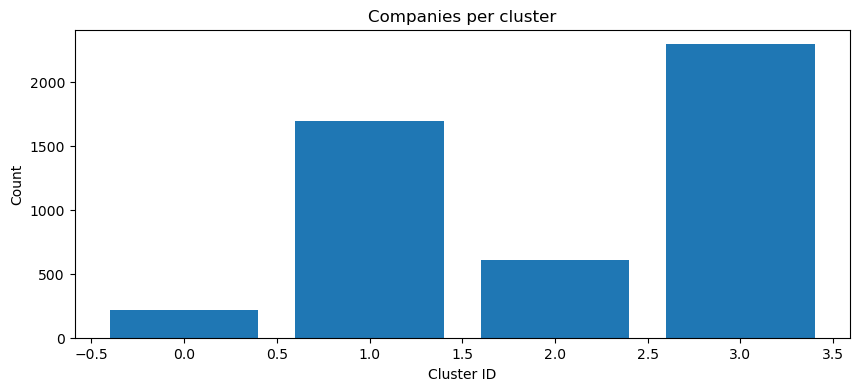

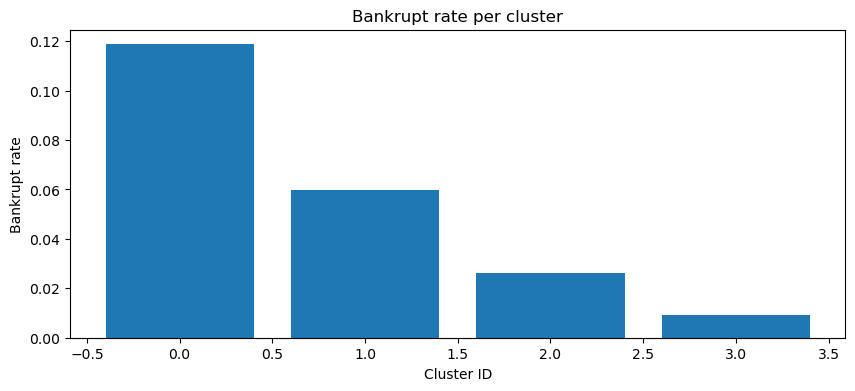

In [9]:
# Visualization: cluster size + bankrupt rate
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(cluster_stats["cluster_id"], cluster_stats["n_companies"])
ax.set_title("Companies per cluster")
ax.set_xlabel("Cluster ID")
ax.set_ylabel("Count")
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(cluster_stats["cluster_id"], cluster_stats["bankrupt_rate"])
ax.set_title("Bankrupt rate per cluster")
ax.set_xlabel("Cluster ID")
ax.set_ylabel("Bankrupt rate")
plt.show()

# Step-3: Identify characteristics (domain-phrased) + visualizations


Cluster 0: n=219, bankrupt_rate=11.872%


,feature,domain_bucket,direction_vs_overall,robust_effect_size,cluster_median,overall_median
0,Fixed Assets Turnover Frequency,Efficiency,higher,12.682163,0.045375,0.000595
1,Current Asset Turnover Rate,Efficiency,higher,0.968177,0.000483,0.000198
2,Total Asset Turnover,Efficiency,lower,-0.590909,0.059970,0.118441
3,Allocation rate per person,Other,higher,0.580366,0.013950,0.007790
4,Net Income to Total Assets,Profitability,lower,-0.542685,0.794510,0.810873
5,Current Liability to Current Assets,Leverage / Solvency,higher,0.537798,0.038675,0.027703
6,Net Income to Stockholder's Equity,Profitability,lower,-0.537122,0.839974,0.841190
7,Retained Earnings to Total Assets,Other,lower,-0.514344,0.930657,0.937736
8,After-tax net Interest Rate,Profitability,lower,-0.511168,0.809296,0.809377
9,Pre-tax net Interest Rate,Profitability,lower,-0.505914,0.797367,0.797465


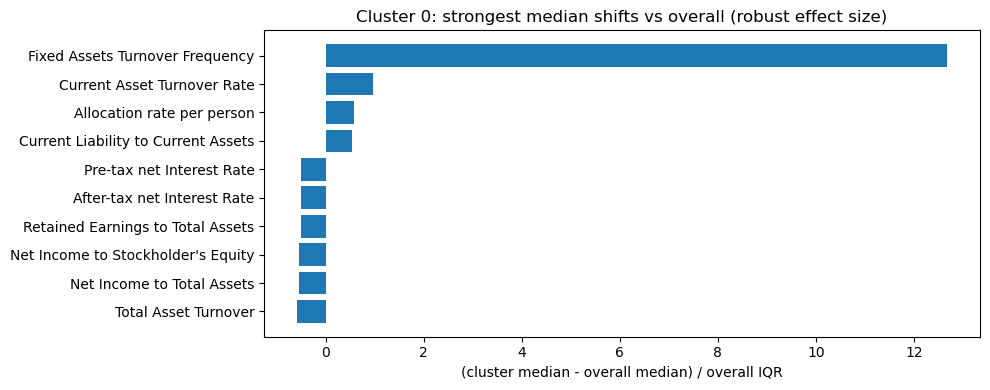


Cluster 1: n=1695, bankrupt_rate=5.959%


,feature,domain_bucket,direction_vs_overall,robust_effect_size,cluster_median,overall_median
0,Tax rate (A),Other,lower,-0.358709,0.000000,0.073692
1,Net Income to Total Assets,Profitability,lower,-0.340653,0.800601,0.810873
2,Net Income to Stockholder's Equity,Profitability,lower,-0.325475,0.840453,0.841190
3,Net profit before tax/Paid-in capital,Profitability,lower,-0.304348,0.171729,0.178486
4,Retained Earnings to Total Assets,Other,lower,-0.301445,0.933587,0.937736
5,Per Share Net profit before tax (Yuan ¥),Profitability,lower,-0.299674,0.172780,0.179709
6,Persistent EPS in the Last Four Seasons,Profitability,lower,-0.298039,0.217358,0.224544
7,ROA(A) before interest and % after tax,Profitability,lower,-0.295775,0.544156,0.560183
8,Operating Profit Per Share (Yuan ¥),Profitability,lower,-0.291498,0.098445,0.104307
9,Operating profit/Paid-in capital,Profitability,lower,-0.288059,0.098450,0.104166


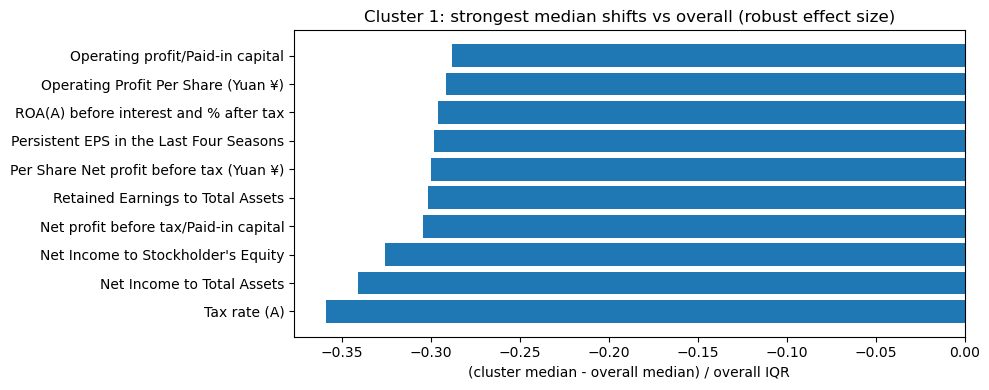


Cluster 2: n=609, bankrupt_rate=2.627%


,feature,domain_bucket,direction_vs_overall,robust_effect_size,cluster_median,overall_median
0,Cash Turnover Rate,Liquidity,higher,0.323851,2.540000e+09,1.060000e+09
1,Quick Asset Turnover Rate,Efficiency,higher,0.209874,9.990000e+08,2.202150e-04
2,Inventory/Working Capital,Liquidity,higher,0.142391,2.772307e-01,2.771749e-01
3,Net Worth Turnover Rate (times),Efficiency,higher,0.138462,3.241935e-02,2.951613e-02
4,Total Asset Turnover,Efficiency,higher,0.136364,1.319340e-01,1.184408e-01
5,Revenue Per Share (Yuan ¥),Other,higher,0.133135,3.105102e-02,2.698247e-02
6,Working capitcal Turnover Rate,Efficiency,lower,-0.124792,5.939539e-01,5.939623e-01
7,Net Value Growth Rate,Growth / Scale,higher,0.118671,4.691920e-04,4.622550e-04
8,Total Asset Growth Rate,Growth / Scale,higher,0.116054,6.710000e+09,6.410000e+09
9,Degree of Financial Leverage (DFL),Leverage / Solvency,higher,0.105424,2.682081e-02,2.680795e-02


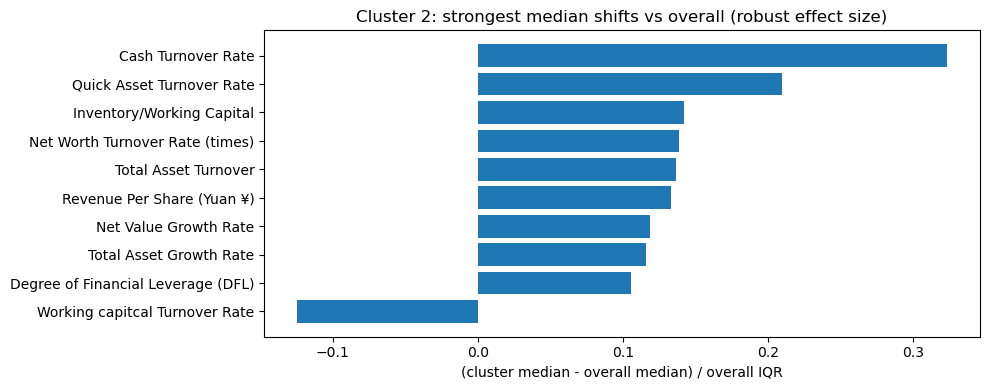


Cluster 3: n=2296, bankrupt_rate=0.915%


,feature,domain_bucket,direction_vs_overall,robust_effect_size,cluster_median,overall_median
0,Tax rate (A),Other,higher,0.317566,1.389311e-01,7.369167e-02
1,Operating profit/Paid-in capital,Profitability,higher,0.228765,1.087050e-01,1.041656e-01
2,Operating Profit Per Share (Yuan ¥),Profitability,higher,0.222672,1.087859e-01,1.043075e-01
3,Persistent EPS in the Last Four Seasons,Profitability,higher,0.215686,2.297438e-01,2.245438e-01
4,Research and development expense rate,Other,higher,0.215297,1.320000e+09,5.600000e+08
5,Per Share Net profit before tax (Yuan ¥),Profitability,higher,0.214984,1.846803e-01,1.797093e-01
6,Net Income to Total Assets,Profitability,higher,0.213675,8.173160e-01,8.108731e-01
7,Net profit before tax/Paid-in capital,Profitability,higher,0.213655,1.832290e-01,1.784858e-01
8,ROA(A) before interest and % after tax,Profitability,higher,0.210262,5.715765e-01,5.601832e-01
9,ROA(C) before interest and depreciation before...,Profitability,higher,0.209217,5.154536e-01,5.029493e-01


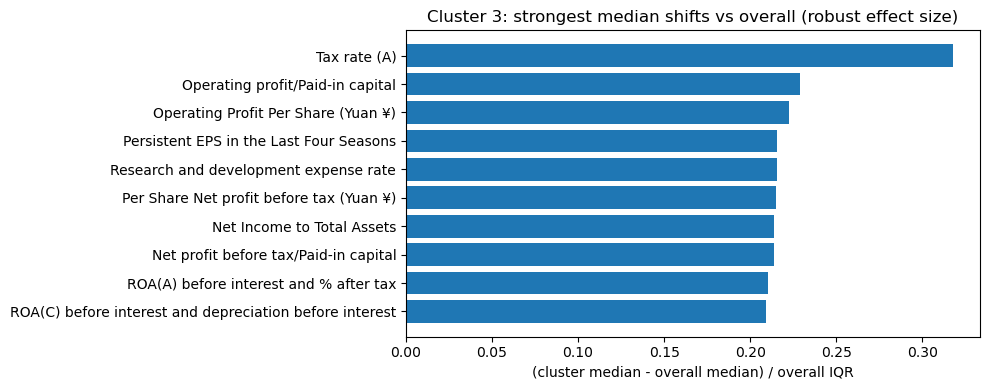

In [10]:
def feature_domain_bucket(name: str) -> str:
    n = name.lower()
    if any(k in n for k in ["roa", "roe", "profit", "margin", "net income", "eps", "interest rate"]):
        return "Profitability"
    if any(k in n for k in ["debt", "liability", "leverage", "equity", "borrow", "coverage"]):
        return "Leverage / Solvency"
    if any(k in n for k in ["current ratio", "quick ratio", "cash", "working capital", "no-credit", "interval"]):
        return "Liquidity"
    if any(k in n for k in ["cash flow", "cfo", "operating funds"]):
        return "Cash Flow"
    if any(k in n for k in ["turnover", "days", "cycle", "inventory", "receivable"]):
        return "Efficiency"
    if any(k in n for k in ["growth", "gnp", "price", "expansion"]):
        return "Growth / Scale"
    return "Other"

X_raw_for_profile = train_df.drop(columns=[TARGET_COL] + ([INDEX_COL] if INDEX_COL else []) + ["cluster_id"]).copy()

global_median = X_raw_for_profile.median(numeric_only=True)
global_q75 = X_raw_for_profile.quantile(0.75, numeric_only=True)
global_q25 = X_raw_for_profile.quantile(0.25, numeric_only=True)
global_iqr = (global_q75 - global_q25).replace(0, np.nan)

def cluster_characteristics(cluster_id: int, top_n: int = 12):
    mask = train_df["cluster_id"].values == cluster_id
    cluster_med = X_raw_for_profile.loc[mask].median(numeric_only=True)

    effect = (cluster_med - global_median) / global_iqr
    effect = effect.replace([np.inf, -np.inf], np.nan).dropna()
    top = effect.abs().sort_values(ascending=False).head(top_n).index.tolist()

    rows = []
    for f in top:
        direction = "higher" if effect[f] > 0 else "lower"
        rows.append({
            "feature": f,
            "domain_bucket": feature_domain_bucket(f),
            "direction_vs_overall": direction,
            "robust_effect_size": float(effect[f]),
            "cluster_median": float(cluster_med[f]),
            "overall_median": float(global_median[f]),
        })

    return pd.DataFrame(rows), effect[top].sort_values()

# Print + plot for each cluster
for cid in range(BEST_K):
    df_char, eff = cluster_characteristics(cid, top_n=10)
    print("\n" + "="*80)
    print(f"Cluster {cid}: n={int((train_df['cluster_id']==cid).sum())}, bankrupt_rate={cluster_stats.loc[cluster_stats.cluster_id==cid,'bankrupt_rate'].iloc[0]:.3%}")
    display(df_char)

    # Bar plot of effect sizes (domain-relevant signals)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.barh(eff.index, eff.values)
    ax.set_title(f"Cluster {cid}: strongest median shifts vs overall (robust effect size)")
    ax.set_xlabel("(cluster median - overall median) / overall IQR")
    plt.tight_layout()
    plt.show()

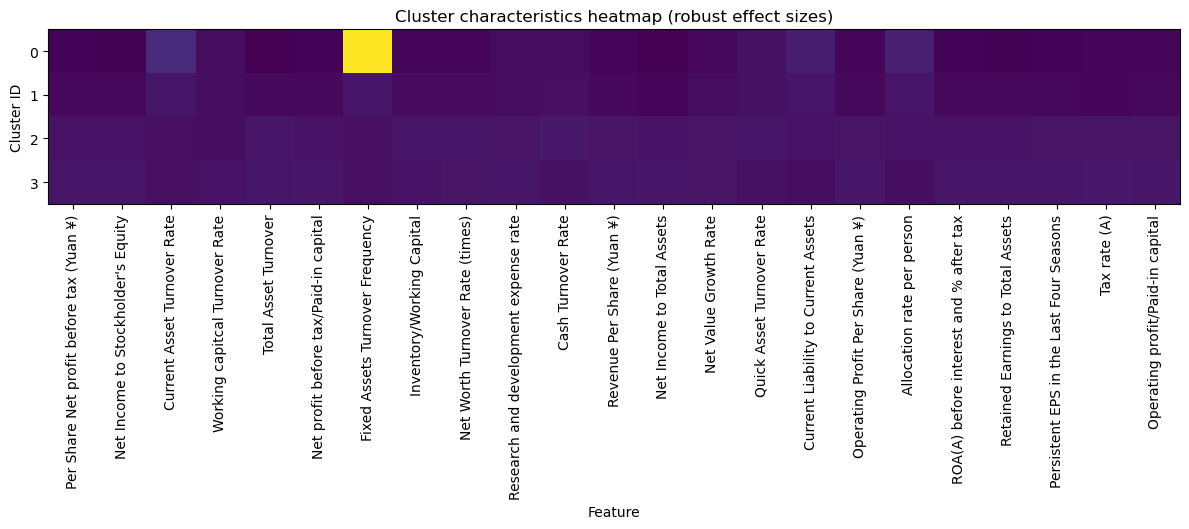

In [11]:
# Heatmap across clusters for a shared set of discriminating features
# Pick top features across all clusters
all_top = set()
for cid in range(BEST_K):
    df_char, _ = cluster_characteristics(cid, top_n=8)
    all_top |= set(df_char["feature"].tolist())

all_top = list(all_top)
heat = []
for cid in range(BEST_K):
    mask = train_df["cluster_id"].values == cid
    cluster_med = X_raw_for_profile.loc[mask, all_top].median(numeric_only=True)
    effect = ((cluster_med - global_median[all_top]) / global_iqr[all_top]).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    heat.append(effect.values)

heat = np.vstack(heat)

fig, ax = plt.subplots(figsize=(12, 4 + 0.35*BEST_K))
im = ax.imshow(heat, aspect="auto")
ax.set_title("Cluster characteristics heatmap (robust effect sizes)")
ax.set_xlabel("Feature")
ax.set_ylabel("Cluster ID")
ax.set_yticks(np.arange(BEST_K))
ax.set_yticklabels([str(i) for i in range(BEST_K)])
ax.set_xticks(np.arange(len(all_top)))
ax.set_xticklabels(all_top, rotation=90)
plt.tight_layout()
plt.show()

# Step-6: Train supervised model to predict subgroup (cluster ID) and save

In [12]:
# We train to mimic the GMM cluster IDs (labels)
y_cluster = train_df["cluster_id"].astype(int).values

cluster_id_model = Pipeline(steps=[
    ("cluster_preprocess", cluster_preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

cluster_id_model.fit(X_train_raw, y_cluster)

dump(cluster_id_model, ARTIFACT_DIR / "cluster_id_model.joblib")
print("Saved:", ARTIFACT_DIR / "cluster_id_model.joblib")

# Quick sanity check (training accuracy on cluster labels; should usually be fairly high)
train_cluster_pred = cluster_id_model.predict(X_train_raw)
print("Train accuracy predicting cluster IDs:", (train_cluster_pred == y_cluster).mean())


Saved: artifacts/cluster_id_model.joblib
Train accuracy predicting cluster IDs: 1.0


### Train per-cluster bankruptcy models (stacking) + thresholds, then save

In [13]:
X_train_core = core_preprocess.transform(X_train_raw)

def tune_threshold_for_recall(y_true, y_proba, beta=2.0):
    # choose threshold that maximizes F-beta on precision-recall curve (beta>1 emphasizes recall)
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # thresholds has length = len(precision)-1
    if thresholds.size == 0:
        return 0.5
    fbeta = (1 + beta**2) * (precision[:-1] * recall[:-1]) / np.maximum(beta**2 * precision[:-1] + recall[:-1], 1e-12)
    best_idx = int(np.nanargmax(fbeta))
    return float(thresholds[best_idx])

def build_stacking_bankruptcy_model():
    base = [
        ("lr", LogisticRegression(
            max_iter=3000,
            solver="saga",
            class_weight="balanced",
            random_state=RANDOM_STATE
        )),
        ("et", ExtraTreesClassifier(
            n_estimators=800,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight="balanced_subsample"
        )),
        ("rf", RandomForestClassifier(
            n_estimators=600,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight="balanced_subsample"
        )),
    ]
    final = LogisticRegression(
        max_iter=3000,
        solver="lbfgs",
        class_weight="balanced",
        random_state=RANDOM_STATE
    )
    return StackingClassifier(
        estimators=base,
        final_estimator=final,
        stack_method="predict_proba",
        passthrough=False,
        n_jobs=-1
    )

# Global fallback model
global_model = build_stacking_bankruptcy_model()
global_model.fit(X_train_core, y_train)

# Out-of-fold probabilities for threshold tuning (global)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
global_oof = cross_val_predict(global_model, X_train_core, y_train, cv=cv, method="predict_proba")[:, 1]
global_thr = tune_threshold_for_recall(y_train, global_oof, beta=2.0)

print("Global tuned threshold:", global_thr)

# Per-cluster models
models_by_cluster = {}
thresholds_by_cluster = {}

MIN_POS_TO_TRAIN = 15  # adjust if you want stricter/looser

for cid in range(BEST_K):
    idx = np.where(y_cluster == cid)[0]
    y_c = y_train[idx]
    X_c = X_train_core[idx]

    pos = int(y_c.sum())
    n = int(len(idx))

    if pos < MIN_POS_TO_TRAIN or len(np.unique(y_c)) < 2:
        models_by_cluster[cid] = global_model
        thresholds_by_cluster[cid] = global_thr
        print(f"Cluster {cid}: n={n}, pos={pos} -> using GLOBAL fallback")
        continue

    m = build_stacking_bankruptcy_model()
    m.fit(X_c, y_c)

    # threshold tuning using OOF probabilities inside cluster
    cv_c = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    oof_c = cross_val_predict(m, X_c, y_c, cv=cv_c, method="predict_proba")[:, 1]
    thr_c = tune_threshold_for_recall(y_c, oof_c, beta=2.0)

    models_by_cluster[cid] = m
    thresholds_by_cluster[cid] = thr_c
    print(f"Cluster {cid}: n={n}, pos={pos} -> trained model, tuned thr={thr_c:.4f}")

dump(
    {
        "BEST_K": BEST_K,
        "global_model": global_model,
        "global_threshold": global_thr,
        "models_by_cluster": models_by_cluster,
        "thresholds_by_cluster": thresholds_by_cluster,
    },
    ARTIFACT_DIR / "bankruptcy_models.joblib"
)

print("Saved:", ARTIFACT_DIR / "bankruptcy_models.joblib")


/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Global tuned threshold: 0.7205034206033061
Cluster 0: n=219, pos=26 -> trained model, tuned thr=0.4809


/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Cluster 1: n=1695, pos=101 -> trained model, tuned thr=0.4263
Cluster 2: n=609, pos=16 -> trained model, tuned thr=0.9304


/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dhruv/micromamba/envs/general_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Cluster 3: n=2296, pos=21 -> trained model, tuned thr=0.8370
Saved: artifacts/bankruptcy_models.joblib


# Steps 7–9: Transform test, predict cluster ID, then predict bankruptcy

Confusion matrix [[TN, FP],[FN, TP]]:
 [[861  93]
 [  8  26]]
Standard accuracy: 0.8978
Equation 1 (Recall for y=1): 0.7647

Classification report:
               precision    recall  f1-score   support

           0     0.9908    0.9025    0.9446       954
           1     0.2185    0.7647    0.3399        34

    accuracy                         0.8978       988
   macro avg     0.6046    0.8336    0.6422       988
weighted avg     0.9642    0.8978    0.9238       988



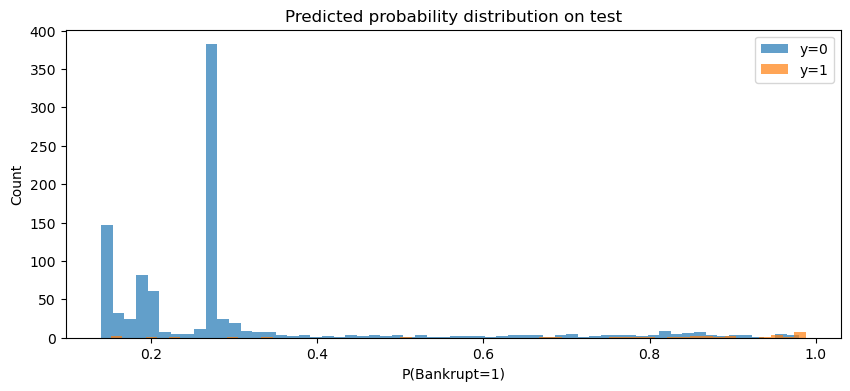

In [14]:
# Load artifacts
bundle = load(ARTIFACT_DIR / "preprocess_bundle.joblib")
core_preprocess = bundle["core_preprocess"]

cluster_id_model = load(ARTIFACT_DIR / "cluster_id_model.joblib")
bankruptcy_pack = load(ARTIFACT_DIR / "bankruptcy_models.joblib")

BEST_K = bankruptcy_pack["BEST_K"]
models_by_cluster = bankruptcy_pack["models_by_cluster"]
thresholds_by_cluster = bankruptcy_pack["thresholds_by_cluster"]

# Prepare test
test_df = test_df.copy()
test_df.columns = [c.strip() for c in test_df.columns]

drop_cols = [bundle["TARGET_COL"]]
if bundle["INDEX_COL"] is not None and bundle["INDEX_COL"] in test_df.columns:
    drop_cols.append(bundle["INDEX_COL"])

X_test_raw = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns]).copy()
y_test = test_df[bundle["TARGET_COL"]].astype(int).values if bundle["TARGET_COL"] in test_df.columns else None

# Step 7: Transform test using saved preprocessing
X_test_core = core_preprocess.transform(X_test_raw)

# Step 8: Predict cluster IDs using saved supervised cluster model
test_cluster_pred = cluster_id_model.predict(X_test_raw)

# Step 9: Predict bankruptcy using cluster-specific model + cluster-specific threshold
proba = np.zeros(len(X_test_raw), dtype=float)
y_pred = np.zeros(len(X_test_raw), dtype=int)

for i in range(len(X_test_raw)):
    cid = int(test_cluster_pred[i])
    model = models_by_cluster.get(cid, bankruptcy_pack["global_model"])
    thr = thresholds_by_cluster.get(cid, bankruptcy_pack["global_threshold"])
    p = float(model.predict_proba(X_test_core[i:i+1])[:, 1][0])
    proba[i] = p
    y_pred[i] = 1 if p >= thr else 0

# Evaluate
if y_test is not None:
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    std_acc = accuracy_score(y_test, y_pred)
    eq1_recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    print("Confusion matrix [[TN, FP],[FN, TP]]:\n", cm)
    print(f"Standard accuracy: {std_acc:.4f}")
    print(f"Equation 1 (Recall for y=1): {eq1_recall:.4f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

    # Helpful plot: probability distribution
    fig, ax = plt.subplots(figsize=(10,4))
    ax.hist(proba[y_test==0], bins=60, alpha=0.7, label="y=0")
    ax.hist(proba[y_test==1], bins=60, alpha=0.7, label="y=1")
    ax.set_title("Predicted probability distribution on test")
    ax.set_xlabel("P(Bankrupt=1)")
    ax.set_ylabel("Count")
    ax.legend()
    plt.show()
else:
    print("No test labels found; outputting predictions only.")
    test_df["pred_cluster_id"] = test_cluster_pred
    test_df["pred_bankrupt_proba"] = proba
    test_df["pred_bankrupt"] = y_pred
    test_df.head()


### Predict for newly observed companies

In [15]:
def predict_new_companies(new_df: pd.DataFrame):
    new_df = new_df.copy()
    new_df.columns = [c.strip() for c in new_df.columns]

    # Drop index col if present
    if bundle["INDEX_COL"] is not None and bundle["INDEX_COL"] in new_df.columns:
        new_df = new_df.drop(columns=[bundle["INDEX_COL"]])

    # Predict cluster via saved supervised model
    cluster_hat = cluster_id_model.predict(new_df)

    # Preprocess + bankruptcy prediction
    X_new_core = core_preprocess.transform(new_df)
    proba = np.zeros(len(new_df), dtype=float)
    yhat = np.zeros(len(new_df), dtype=int)

    for i in range(len(new_df)):
        cid = int(cluster_hat[i])
        model = models_by_cluster.get(cid, bankruptcy_pack["global_model"])
        thr = thresholds_by_cluster.get(cid, bankruptcy_pack["global_threshold"])
        p = float(model.predict_proba(X_new_core[i:i+1])[:, 1][0])
        proba[i] = p
        yhat[i] = 1 if p >= thr else 0

    out = new_df.copy()
    out["pred_cluster_id"] = cluster_hat
    out["pred_bankrupt_proba"] = proba
    out["pred_bankrupt"] = yhat
    return out